In [108]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
from decouple import config
import locale
import seaborn as sns
import matplotlib.pyplot as plt
import tempfile

pd.options.display.float_format = lambda x: '{:,.2f}'.format(x)

# Establecemos el locale para usar el formato español (o de otros países que usan punto para miles y coma para decimales)
locale.setlocale(locale.LC_ALL, 'es_ES.UTF-8')

engine = sql.create_engine('mssql+pyodbc://IPSDB-Replica/Liquidacion?driver=ODBC+Driver+17+for+SQL+Server')
engine_plus = sql.create_engine('mssql+pyodbc://IPSBD\\Plus/Liquidacion?driver=ODBC+Driver+17+for+SQL+Server')
engine_refuerzo = sql.create_engine('mssql+pyodbc://IPSBD\\PlusExtra/Liquidacion?driver=ODBC+Driver+17+for+SQL+Server')

liquidacion = config("LIQUIDACION")

In [109]:
cons_creditos = f"""SELECT L.PLLA, L.ORDEN, L.AFILIADO, SUM(MONTO) AS CREDITOS
FROM [{liquidacion}].dbo.Liquidacion L
INNER JOIN Codigos C ON C.CODIGO=L.CODIGO
WHERE C.TIPO='C'
--AND L.CODIGO NOT IN ('05','07','0Y')
GROUP BY L.PLLA, L.ORDEN, L.AFILIADO""".format(liquidacion)

creditos = pd.read_sql(cons_creditos, engine)
cons_beneficios = f"""SELECT D.CONTROL, D.PLLA, D.ORDEN, D.AFILIADO, D.SEXO, DL.BENEFICIO, B.DETALLE AS BENEFICIO_TIPO, B.TIPO,
R.DETALLE AS REPARTICION, R.TIPOREPARTICION FROM DATOSAFILIADO D INNER JOIN BENEFICIO B ON B.COD=COD_BENEFICIO
INNER JOIN REPARTICION R ON R.COD=LETRA
INNER JOIN [{liquidacion}].dbo.DatosAfiliado DL on DL.CONTROL=D.CONTROL""".format(liquidacion=liquidacion)

beneficios = pd.read_sql(cons_beneficios, engine)
brutos = beneficios.merge(creditos, on=['PLLA', 'ORDEN', 'AFILIADO'], how='left').fillna(0.0)

brutos["BRUTO"] = brutos["BENEFICIO"] + brutos["CREDITOS"]

In [110]:

cons_creditos_plus = f"""SELECT L.PLLA, L.ORDEN, L.AFILIADO, SUM(MONTO) AS CREDITOS
FROM [{liquidacion}].dbo.Liquidacion L
INNER JOIN Codigos C ON C.CODIGO=L.CODIGO
WHERE C.TIPO='C'
GROUP BY L.PLLA, L.ORDEN, L.AFILIADO""".format(liquidacion)

creditos_plus = pd.read_sql(cons_creditos_plus, engine_plus)
cons_beneficios_plus = f"""SELECT D.CONTROL, D.PLLA, D.ORDEN, D.AFILIADO, D.SEXO, DL.BENEFICIO, B.DETALLE AS BENEFICIO_TIPO, B.TIPO, 
R.DETALLE AS REPARTICION, R.TIPOREPARTICION FROM DATOSAFILIADO D INNER JOIN BENEFICIO B ON B.COD=COD_BENEFICIO
INNER JOIN REPARTICION R ON R.COD=LETRA
INNER JOIN [{liquidacion}].dbo.DatosAfiliado DL on DL.CONTROL=D.CONTROL""".format(liquidacion=liquidacion)

beneficios_plus = pd.read_sql(cons_beneficios_plus, engine_plus)
brutos_plus = beneficios_plus.merge(creditos_plus, on=['PLLA', 'ORDEN', 'AFILIADO'], how='left').fillna(0.0)

brutos_plus["BRUTO"] = brutos_plus["BENEFICIO"] + brutos_plus["CREDITOS"]

In [111]:

cons_creditos_refuerzo = f"""SELECT L.PLLA, L.ORDEN, L.AFILIADO, SUM(MONTO) AS CREDITOS
FROM [{liquidacion}].dbo.Liquidacion L
INNER JOIN Codigos C ON C.CODIGO=L.CODIGO
WHERE C.TIPO='C'
GROUP BY L.PLLA, L.ORDEN, L.AFILIADO""".format(liquidacion)

creditos_refuerzo = pd.read_sql(cons_creditos_refuerzo, engine_refuerzo)
cons_beneficios_refuerzo = f"""SELECT D.CONTROL, D.PLLA, D.ORDEN, D.AFILIADO, D.SEXO, DL.BENEFICIO, B.DETALLE AS BENEFICIO_TIPO, B.TIPO,
R.DETALLE AS REPARTICION FROM DATOSAFILIADO D INNER JOIN BENEFICIO B ON B.COD=COD_BENEFICIO
INNER JOIN REPARTICION R ON R.COD=LETRA
INNER JOIN [{liquidacion}].dbo.DatosAfiliado DL on DL.CONTROL=D.CONTROL""".format(liquidacion=liquidacion)

beneficios_refuerzo = pd.read_sql(cons_beneficios_refuerzo, engine_refuerzo)
brutos_refuerzo = beneficios_refuerzo.merge(creditos_refuerzo, on=['PLLA', 'ORDEN', 'AFILIADO'], how='left').fillna(0.0)

brutos_refuerzo["BRUTO"] = brutos_refuerzo["BENEFICIO"] + brutos_refuerzo["CREDITOS"]

brutos["TIPOREPARTICION"] = brutos["TIPOREPARTICION"].replace({"NO": "Org.\nDescentr.",
    "SP": "Salud Pública", "AC": "Adm. Central", "MOVILIDADES": "Movil. Varias",
    "Legisladores": "Legislativo", "DOC": "Docente", "JUPOLICIA": "Policia", "MG": "Adm. Central"})

In [112]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

costos = [ brutos["BRUTO"].sum(), brutos_plus["BRUTO"].sum(), brutos_refuerzo["BRUTO"].sum()]

sns.set_theme("paper")
sns.set_style("white")
fig = plt.figure(figsize=(4,4))
sector, textos, autotextos = plt.pie(costos, autopct=lambda p:f'{p:.2f}%\n(${p*sum(costos)/1e8 :.0f}M)', 
    shadow=False, startangle=90, labels=["Haberes", "Plus\nUnificado", "Plus\nRefuerzo"], 
    labeldistance=1.2, pctdistance=0.84, textprops={"fontsize":7})

for autotext in autotextos:
    autotext.set_color('white')
    #autotext.set_weight('bold')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.tight_layout()

#plt.title("Costo Total", loc="center", fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})

temp_pie_costo = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_pie_costo.name)
#plt.show()
plt.close()


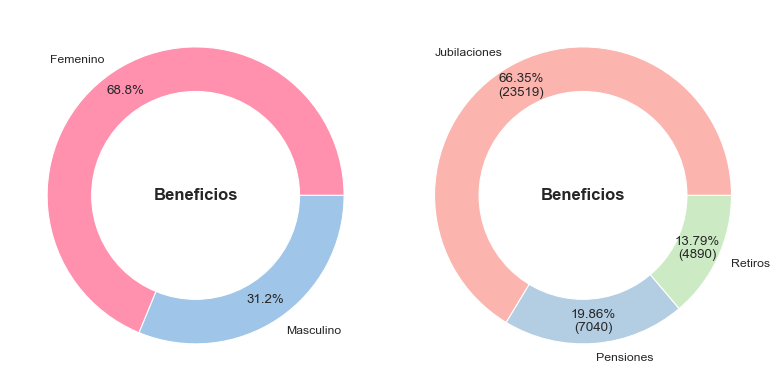

In [114]:
import matplotlib.pyplot as plt
from matplotlib import cm

cmap = plt.get_cmap("Pastel1")
colores = [cmap(i) for i in range(3)]

fig, axs = plt.subplots(1, 2, figsize=(8,4))

brutos["SEXO"] = brutos.apply(lambda x: "Masculino" if x["SEXO"] == "M" else "Femenino" if x["SEXO"] == "F" else x["SEXO"], axis=1)
brutos.groupby("SEXO")["SEXO"].count().plot.pie(ax=axs[0], y="BRUTO", autopct="%1.1f%%", label='',
    colors=["#ff91af","#9fc5e8"], pctdistance=0.85)
#axs[0].set_title("Beneficios por sexo", fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})

centre_circle = plt.Circle((0,0),0.70,fc='white')
axs[0].add_artist(centre_circle)
axs[0].text(0, 0, 'Beneficios', horizontalalignment='center', verticalalignment='center', fontsize=12, fontweight='bold')

brutos["TIPO"] = brutos.apply(lambda x: "Retiros" if x["REPARTICION"] \
                            in ("Retiro Policial", "Retiro Carcelario")\
                            else "Pensiones" if x["TIPO"]=='pen' else \
                                'Jubilaciones', axis=1)

brutos.groupby("TIPO").count().plot.pie(ax=axs[1], y="BRUTO", autopct=make_autopct(brutos["TIPO"].value_counts())
    ,colors=colores, label='', pctdistance=0.85)
plt.legend().remove()
#axs[1].set_title('Beneficios por Tipo',  fontdict={'family': 'Arial', 'size': 14, 'weight': 'bold', 'style': 'normal'})

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
axs[1].add_artist(centre_circle)
axs[1].text(0, 0, 'Beneficios', horizontalalignment='center', verticalalignment='center', fontsize=12, fontweight='bold')

plt.tight_layout()

temp_pie_beneficios_sexo_tipo = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_pie_beneficios_sexo_tipo.name)
plt.show()
plt.close()

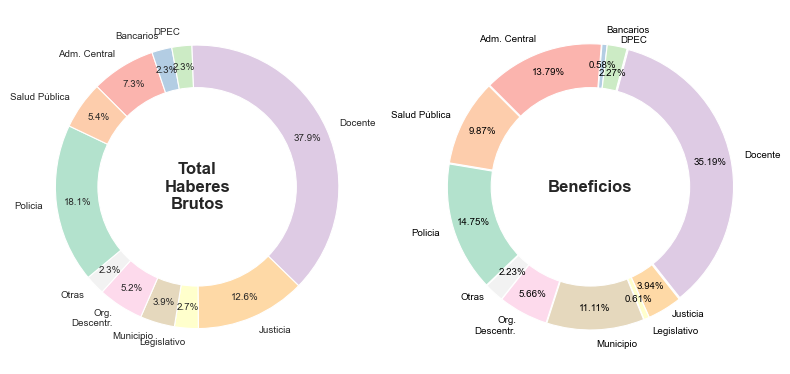

In [115]:
from matplotlib import cm

pastel1 = plt.get_cmap("Pastel1")
pastel2 = plt.get_cmap("Pastel2")

colores = [cmap(i) for i in range(pastel1.N)] + \
    [pastel2(i) for i in range(pastel2.N)]


fig, axs = plt.subplots(1, 2, figsize=(8,4), tight_layout=True, sharey=True)

# Obtener las 10 primeras reparticiones con mayor BRUTO
top_10_reparticiones_bruto = brutos.groupby("TIPOREPARTICION")["BRUTO"].\
    sum().nlargest(10).index

# Calcular el total del BRUTO del resto de las reparticiones
total_resto_reparticiones_bruto = brutos[~brutos['TIPOREPARTICION'].\
    isin(top_10_reparticiones_bruto)]['BRUTO'].sum()

# Crear los datos para el gráfico de pastel
data_top_10_bruto = brutos.loc[brutos['TIPOREPARTICION'].\
    isin(top_10_reparticiones_bruto), ["TIPOREPARTICION", "BRUTO"]]

# Concatenar las series
data_top_10_bruto.loc[len(data_top_10_bruto)] = ["Otras", \
    total_resto_reparticiones_bruto]

data_top_10_bruto_grp = data_top_10_bruto.groupby("TIPOREPARTICION").sum("BRUTO")

plt.subplot(1,2,1) 

sectores, textos, autos = plt.pie(data_top_10_bruto_grp["BRUTO"], \
    labels=data_top_10_bruto_grp.index,  autopct="%1.1f%%", startangle=135,
    pctdistance=0.85, colors=colores[:11], textprops={'fontsize': 7}, 
    wedgeprops={'width': 0.5}, counterclock=False)

for i, aut in enumerate(autos):
        aut.set_fontsize(7)

centre_circle = plt.Circle((0,0),0.70,fc='white')
axs[0].add_artist(centre_circle)
axs[0].text(0, 0, 'Total\nHaberes\nBrutos', horizontalalignment='center', 
            verticalalignment='center', fontsize=12, fontweight='bold')

axs[0].legend().set_visible(False)

###

# Obtener las 10 primeras reparticiones con mayor BRUTO
top_10_reparticiones_cantidad = brutos.groupby("TIPOREPARTICION").count() \
    .nlargest(10, "CONTROL").index

# Calcular el total del BRUTO del resto de las reparticiones
resto_reparticiones = brutos[~brutos['TIPOREPARTICION']\
    .isin(top_10_reparticiones_bruto)]

total_resto_reparticiones = resto_reparticiones.count()["CONTROL"].sum()

# Crear los datos para el gráfico de pastel
data_top_10 = brutos.loc[brutos['TIPOREPARTICION'].\
    isin(top_10_reparticiones_bruto), ["TIPOREPARTICION", "CONTROL"]]


data_top_10_grp = data_top_10.groupby("TIPOREPARTICION").count()["CONTROL"]

# Concatenar las series
data_top_10_grp = pd.concat( [data_top_10_grp, \
    pd.Series({"Otras": total_resto_reparticiones})] )

data_top_10_grp = data_top_10_grp.sort_index()  


plt.subplot(1,2,2)
sectores, textos, autos = plt.pie(x=data_top_10_grp, labels=data_top_10_grp.index, 
        autopct=lambda p:f'{p:.2f}%', 
        shadow=False, startangle=135, explode=[0.01] * len(data_top_10_grp), 
        pctdistance=0.85, colors=colores[:11], counterclock=False,
        textprops={"fontsize": 7, "color": "black"})

"""desplazar los textos para que no se pisen
cuando los sectores son pequeños"""
for i, aut in enumerate(autos):
    if data_top_10_grp.iloc[i] / data_top_10_grp.sum() < 0.05:
        if ((i % 2) == 0):
            x, y = aut.get_position()
            aut.set_position((x * 0.95, y * 0.95)) 
            
for i, texto in enumerate(textos):
    if data_top_10_grp.iloc[i] / data_top_10_grp.sum() < 0.05:
        if ((i % 2) == 0):
            x, y = texto.get_position()
            texto.set_position((x * 1, y * 0.95)) 

centre_circle = plt.Circle((0,0),0.70,fc='white')
axs[1].add_artist(centre_circle)
axs[1].text(0, 0, 'Beneficios', ha='center', va='center', fontsize=12,
            fontweight='bold')

axs[1].legend().set_visible(False)

# plt.text(0.70, -0.30, '*sobre un total de {} beneficios'.\
#     format(data_top_10_grp.sum()),fontsize=8,fontweight='normal',color='gray')

#plt.text(-1.30, -1.37, '**' + ",".join(resto_reparticiones["TIPOREPARTICION"].unique()), fontsize=6, fontweight='normal', color='gray', wrap=True, verticalalignment='top')

plt.legend().set_visible(False)
#plt.title("Beneficios por tipo de repartición", fontdict={'family': 'Arial', 'size': 12,  'weight': 'bold', 'style': 'normal'})
plt.rcParams['savefig.dpi'] = 600 

# Ajustar el layout para reducir el espacio entre los gráficos de pastel
plt.subplots_adjust(wspace=0, hspace=5)

temp_pie_brutos_tr = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_pie_brutos_tr)
plt.show()
plt.close()

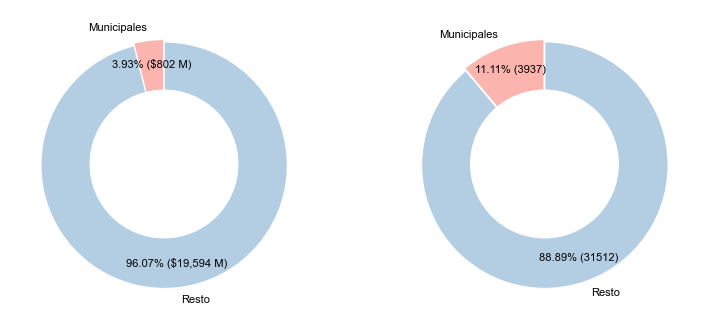

In [116]:
municipales_bruto = brutos.loc[brutos["TIPOREPARTICION"] == "Municipio"]\
    .sum()["BRUTO"]

resto_municipales_bruto = brutos[~(brutos["TIPOREPARTICION"]=="Municipio")]\
    ["BRUTO"].sum()

muni_bruto = pd.concat([pd.Series({"Municipales": municipales_bruto}), 
                        pd.Series({"Resto": resto_municipales_bruto})])

municipales_cantidad = len(brutos.loc[brutos["TIPOREPARTICION"] == "Municipio"])
resto_municipales_cantidad = len(brutos.loc[brutos["TIPOREPARTICION"] \
    != "Municipio"])

muni_cant = pd.concat([pd.Series({"Municipales": municipales_cantidad}), \
    pd.Series({"Resto": resto_municipales_cantidad})])

fig, ax = plt.subplots(1, 2, figsize=(9,4))
#plt.figtext(0.5, 0.9, 'Beneficiarios municipales', fontsize=14, ha='center')

plt.subplot(1,2,1)
plt.pie(x=muni_bruto, labels=muni_bruto.index, 
        autopct=lambda p:f'{p:.2f}% (${p*sum(muni_bruto)/100000000 :,.0f} M)', 
        shadow=False, startangle=90, explode=[0.01] * len(muni_cant), 
        pctdistance=0.80, colors=colores[0:2],
        textprops={"fontsize": 8, "color": "black"})

#plt.ylabel(ylabel="Haberes brutos")
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

plt.subplot(1,2,2)
plt.pie(x=muni_cant, labels=muni_cant.index, 
        autopct=lambda p:f'{p:.2f}% ({p*sum(muni_cant)/100 :.0f})', shadow=False,
        startangle=90,explode=[0.01] * len(muni_cant), pctdistance=0.80,
        textprops={"fontsize": 8, "color": "black"}, colors=colores[0:2])
#plt.ylabel(ylabel="Beneficios")
# draw circle
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

temp_pie_municipales = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
plt.savefig(temp_pie_municipales)
plt.show()
plt.close()



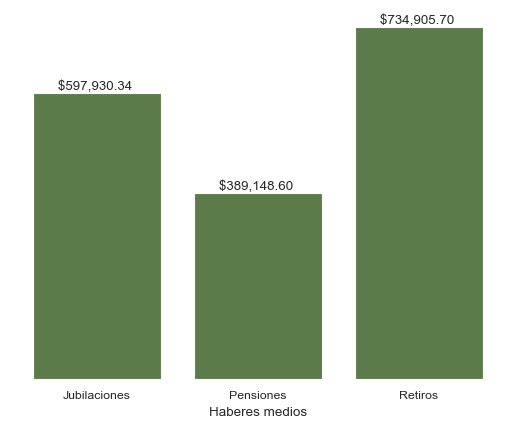

In [191]:
promedios = brutos[["TIPO", "BRUTO"]].groupby("TIPO").mean(["BRUTO"])

fig, ax = plt.subplots()
bars = ax.bar(promedios.index, promedios["BRUTO"], color="#5c7b4b")


for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X posición
        height,                             # Y posición (altura de la barra)
        f'${height:,.2f} ',                        # Texto (valor)
        ha='center',                        # Alineación horizontal
        va='bottom'                         # Alineación vertical
    )
    
# Eliminar los bordes del gráfico (spines)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Opcional: Eliminar las marcas de los ejes
ax.yaxis.set_ticks_position('none')
ax.yaxis.set_visible(False)
ax.xaxis.set_ticks_position('none')

plt.ylabel("")
plt.xlabel("Haberes medios")
#plt.legend().set_visible(False)
plt.show()

In [188]:
from reportlab.lib.pagesizes import A4, landscape
from reportlab.lib.units import mm

from reportlab.pdfgen import canvas

    
# Crear el PDF usando ReportLab
pdf_file = f'informe_{liquidacion}.pdf'
c = canvas.Canvas(pdf_file, pagesize=landscape(A4))
""" CARATULA """
c.setFont('Helvetica-Bold', 24)
c.setFontSize(32)
c.drawString(x=(landscape(A4)[0]/2-100), y=landscape(A4)[1]/2,
            text="Informe IPS " + liquidacion[-2:] + "/" + liquidacion[:4])
c.showPage()
""" PRIMERA PAGINA """

# Insertar el gráfico en el PDF
c.drawImage(temp_pie_costo.name, 30, 100, 800, 400, preserveAspectRatio=True)
temp_pie_costo.close()

c.drawImage("resources/pie.png", 0, 0, landscape(A4)[0], 65, 
            preserveAspectRatio=True, mask='auto')

c.setFont('Helvetica-Bold', 12)
c.setFillColor('white')

c.drawString(420, 25, liquidacion[-2:] + "/" + 
             liquidacion[:4])
c.showPage()
""" FIN PRIMERA PAGINA """


"""" SEGUNDA PAGINA """
c.drawImage(temp_pie_beneficios_sexo_tipo.name, 20,120,800,400, 
            preserveAspectRatio=True)
c.drawImage("resources/pie.png", 0, 0, landscape(A4)[0], 65, 
            preserveAspectRatio=True, mask='auto')

c.setFont('Helvetica-Bold', 12)
c.setFillColor('white')

c.drawString(420, 25, liquidacion[-2:] + "/" + 
             liquidacion[:4])

c.showPage()
temp_pie_beneficios_sexo_tipo.close()


""" TERCERA PAGINA """
#c.setPageSize(landscape(A4))
c.drawImage(temp_pie_brutos_tr.name, 20, 60, width=A4[1]-30, height=A4[0], 
            preserveAspectRatio=True)
c.drawImage("resources/pie.png", 0, 0, landscape(A4)[0], 65, 
            preserveAspectRatio=True, mask='auto')

c.setFont('Helvetica-Bold', 12)
c.setFillColor('white')

c.drawString(420, 25, liquidacion[-2:] + "/" + 
             liquidacion[:4])
c.showPage()
temp_pie_brutos_tr.close()


""" CUARTA PAGINA """
c.drawImage(temp_pie_municipales.name, 15, 10, width=A4[1]-20, height=A4[0], 
            preserveAspectRatio=True)
c.drawImage("resources/pie.png", 0, 0, landscape(A4)[0], 65, 
            preserveAspectRatio=True, mask='auto')

c.setFont('Helvetica-Bold', 12)
c.setFillColor('white')

c.drawString(420, 25, liquidacion[-2:] + "/" + 
             liquidacion[:4])

c.showPage()
temp_pie_municipales.close()


# Insertar el gráfico en el PDF
#c.drawImage(temp_pie_beneficios_sexo_tipo.name, 60, 60, 450, 700, preserveAspectRatio=True)
#temp_pie_beneficios_sexo_tipo.close()

#c.drawString(420, 25, 'IPS Corrientes - ' + liquidacion[-2:] + "/" + liquidacion[:4])
#c.showPage()
""" FIN PRIMERA PAGINA """


c.save()


